In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, sweep_poly
from librosa import cqt,stft, note_to_hz, pseudo_cqt
from librosa.feature import melspectrogram
import sys
sys.path.insert(0,'../')
from scipy.io import wavfile

from nnAudio import Spectrogram
import torch
import torch.nn as nn

In [2]:
cmap = 'jet'
fmin = note_to_hz('A1') # for CQT use

fs = 44100
t = 10
f0 = 55
f1 = 22050

# parameters for CQT
bins_per_octave = 24
n_bins = int(bins_per_octave*7.5)

epsilon = 1e-5 # for taking log

# Getting a log sine sweep

(-499.95000000000005, 10498.95, -4.097799599170685, 4.097871840000153)

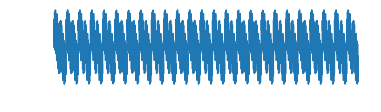

In [3]:
s = np.linspace(0,t, fs*t)

x = np.sin(2*np.pi*110*s, dtype=np.float32) + np.sin(2*np.pi*1760*2*s, dtype=np.float32)\
+ np.sin(2*np.pi*220*s, dtype=np.float32) + np.sin(2*np.pi*440*s, dtype=np.float32)\
+ np.sin(2*np.pi*880*s, dtype=np.float32) + np.sin(2*np.pi*1760*s, dtype=np.float32)
    
# x = chirp(s, f0, 1, f1, method='logarithmic')
x = x.astype(dtype=np.float32)

plt.figure(figsize=(6,1.5))
plt.plot(x[:10000])
plt.axis('off')

# Comparing CQT results

## nnAudio

CQT kernels created, time used = 0.8641 seconds


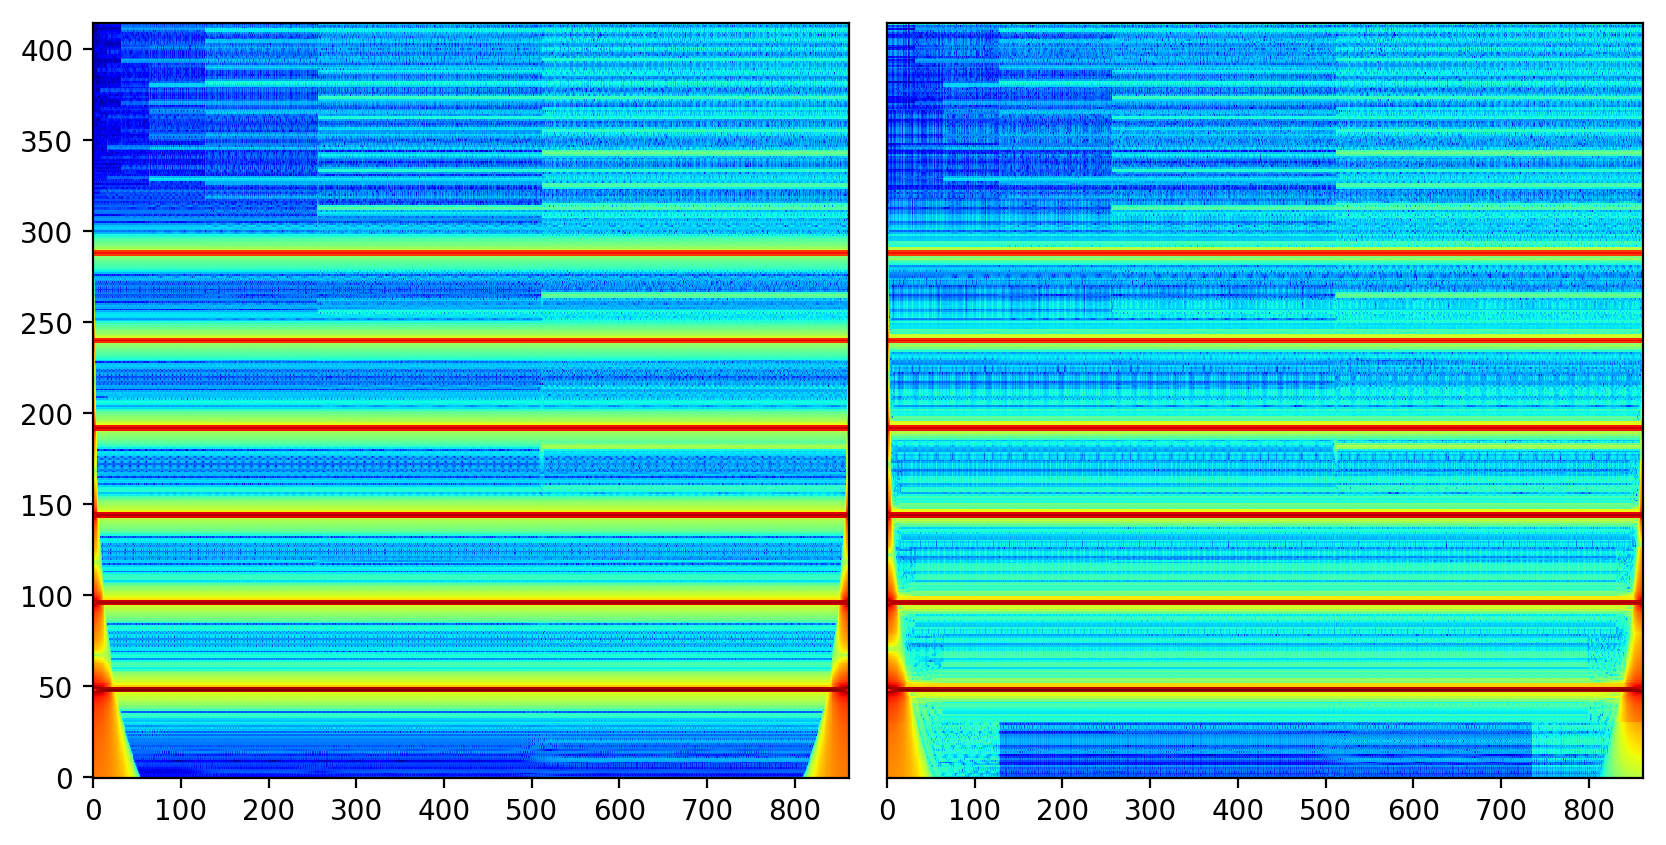

In [4]:
r=4
bins_per_octave = 12*r
n_bins = 104*r-1
CQT2010_layer = Spectrogram.CQT1992v2(fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)

cqt_x = CQT2010_layer(torch.tensor(x[None, None, :]))
output_lib = cqt(x, sr=fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,5))

ax[0].imshow(np.log(cqt_x[0]+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(abs(output_lib)+epsilon), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])

ax[1].set_yticks([])
# ax[0].title.set_text("nnAudio")
# ax[1].title.set_text("Librosa")
fig.subplots_adjust(wspace = 0.05)

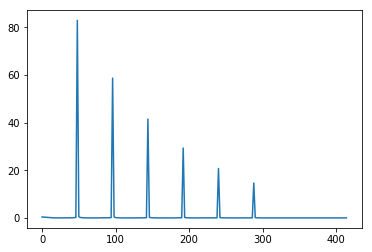

In [5]:
plt.plot((cqt_x[0][:,40].cpu().numpy()))
# plt.plot(abs(output_lib)[:,40])
# plt.legend(['nnAudio','librosa'])

In [6]:
print("Linear sweep all close ", np.allclose(cqt_x[0].numpy(), output_lib, rtol=1.5, atol=1.5))

Linear sweep all close  False


# Melspectrogram

STFT filter created, time used = 0.2574 seconds
Mel filter created, time used = 0.0037 seconds


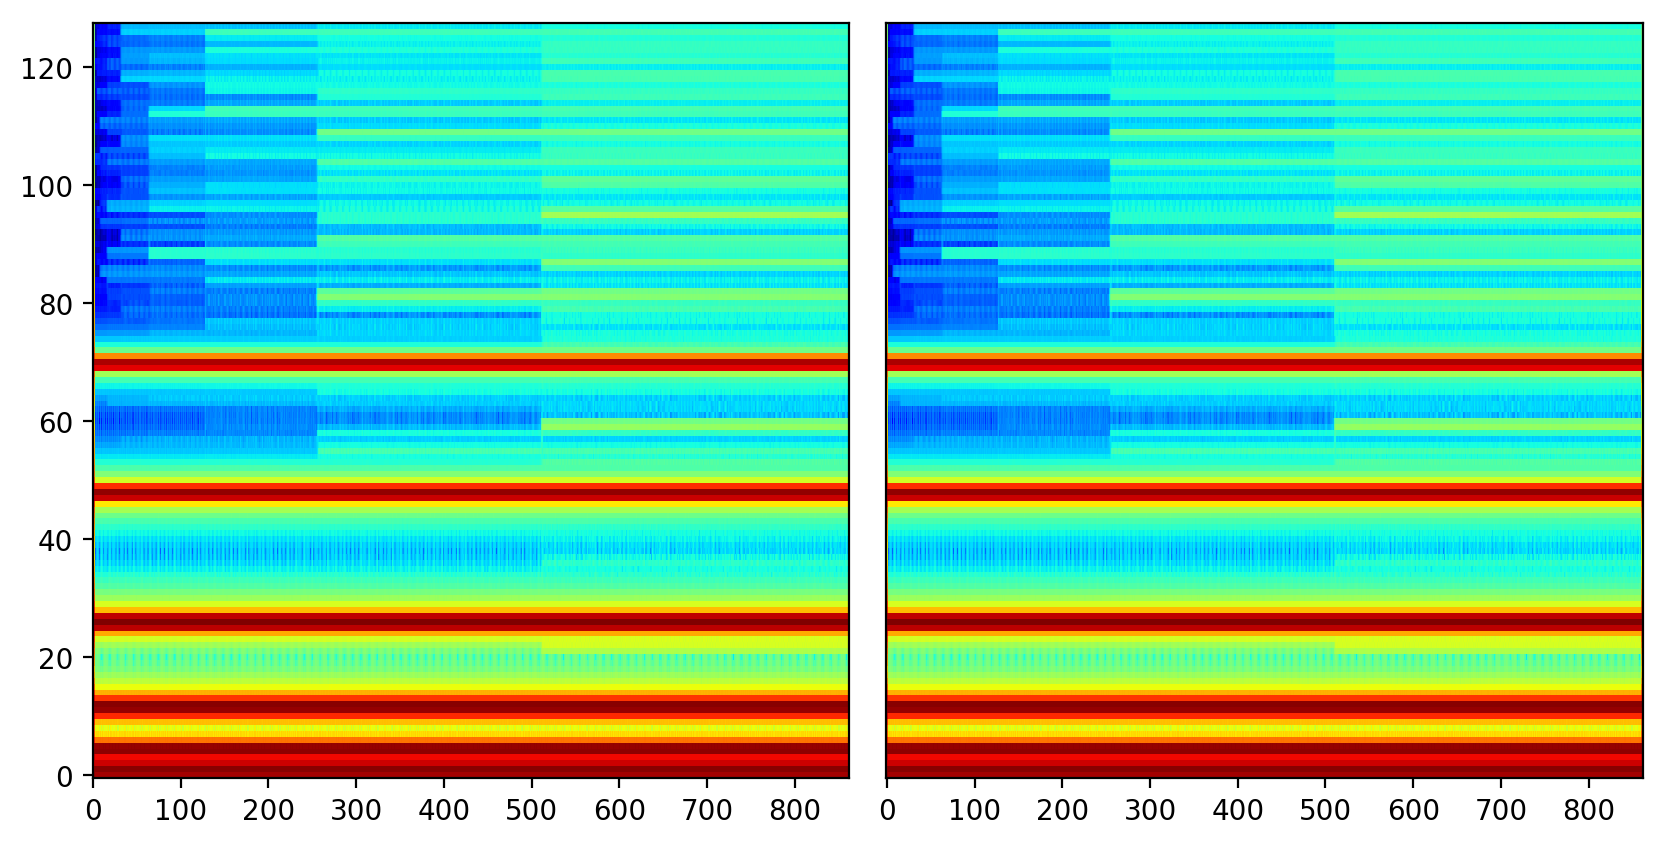

In [7]:
mel_layer = Spectrogram.MelSpectrogram(fs, fmin=fmin)
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,5))
mel_x = mel_layer(torch.tensor(x[None, None, :]))
output_lib = melspectrogram(x, fs, fmin=fmin)
ax[0].imshow(np.log(mel_x[0]), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(output_lib), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
# ax[0].title.set_text("nnAudio")
# ax[1].title.set_text("Librosa")
fig.subplots_adjust(wspace = 0.05)

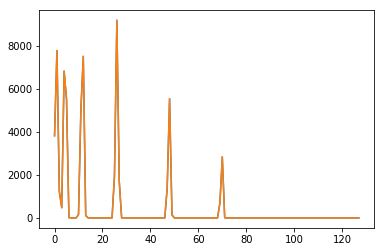

In [8]:
plt.plot(mel_x[0][:,40].cpu().numpy())
plt.plot(output_lib[:,40])

In [9]:
print("Linear sweep all close ", np.allclose(mel_x[0].numpy(), output_lib, rtol=1e-3, atol=1e-4))

Linear sweep all close  True


# STFT linear freq

In [10]:
stft_layer_no = Spectrogram.STFT()
stft_x = stft_layer_no(torch.tensor(x[None, None, :]))

output_lib = abs(stft(x))

STFT kernels created, time used = 0.2085 seconds


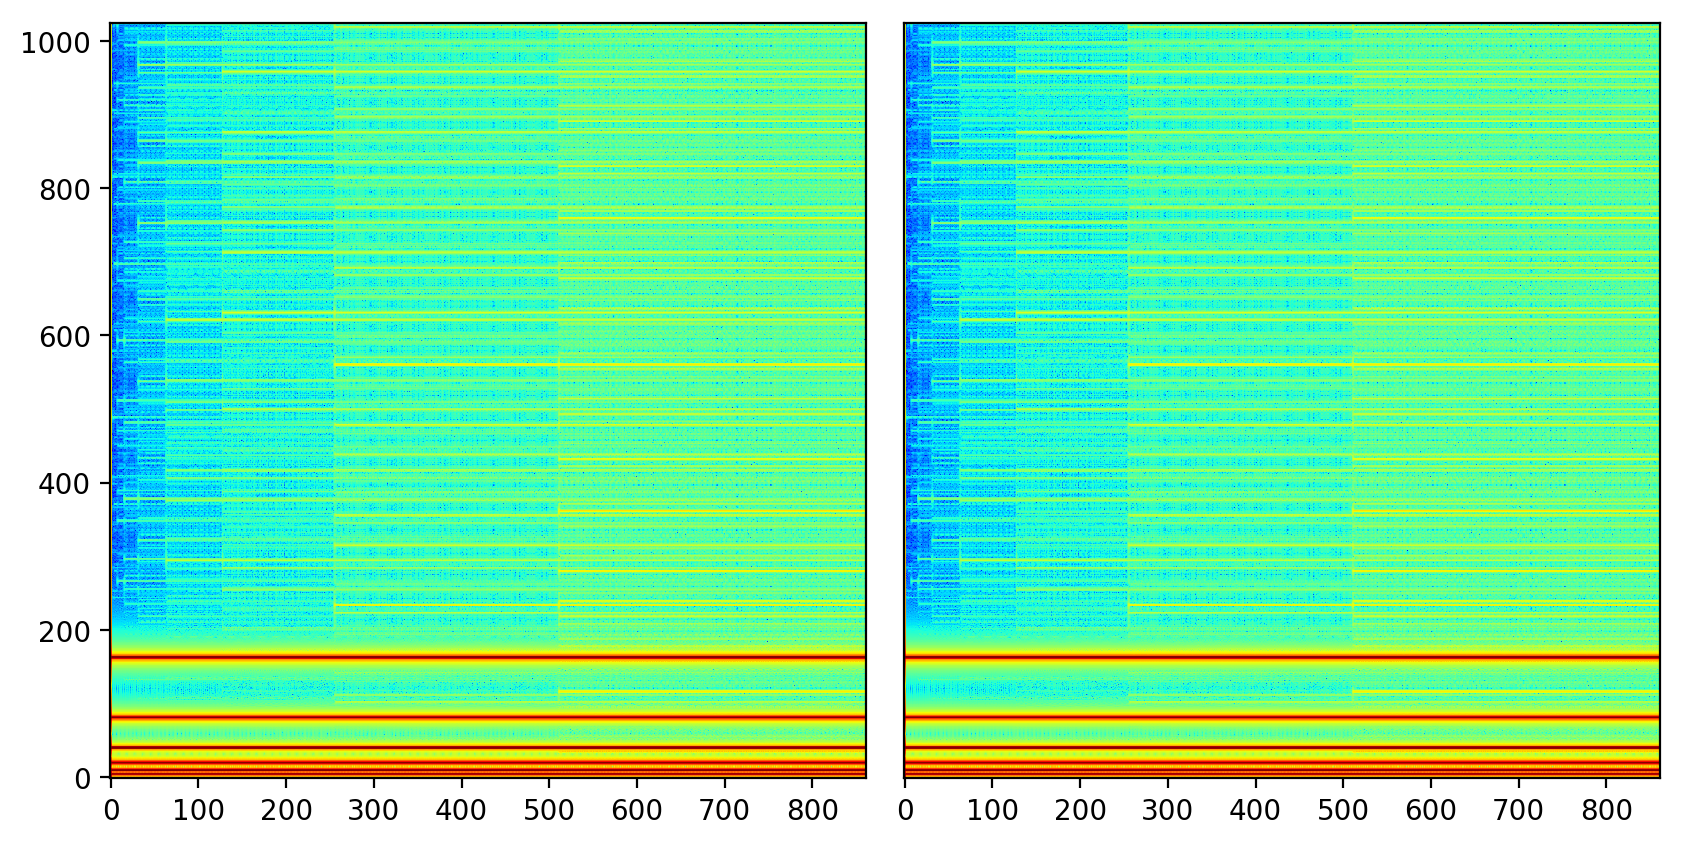

In [11]:
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,5))
ax[0].imshow(np.log(stft_x[0]), aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(np.log(abs(output_lib)), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
# ax[0].title.set_text("nnAudio")
# ax[1].title.set_text("Librosa")
fig.subplots_adjust(wspace = 0.05)

In [12]:
print("Linear sweep all close ", np.allclose(stft_x[0].numpy(), output_lib, rtol=1e-2, atol=1e-2))

Linear sweep all close  True


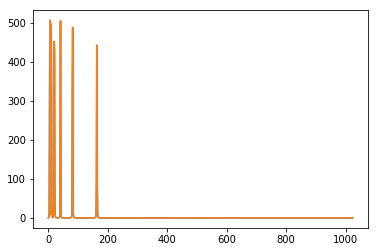

In [18]:
plt.plot(stft_x[0][:,500].cpu().numpy())
plt.plot(output_lib[:,500])

# STFT log-freq

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.2038 seconds


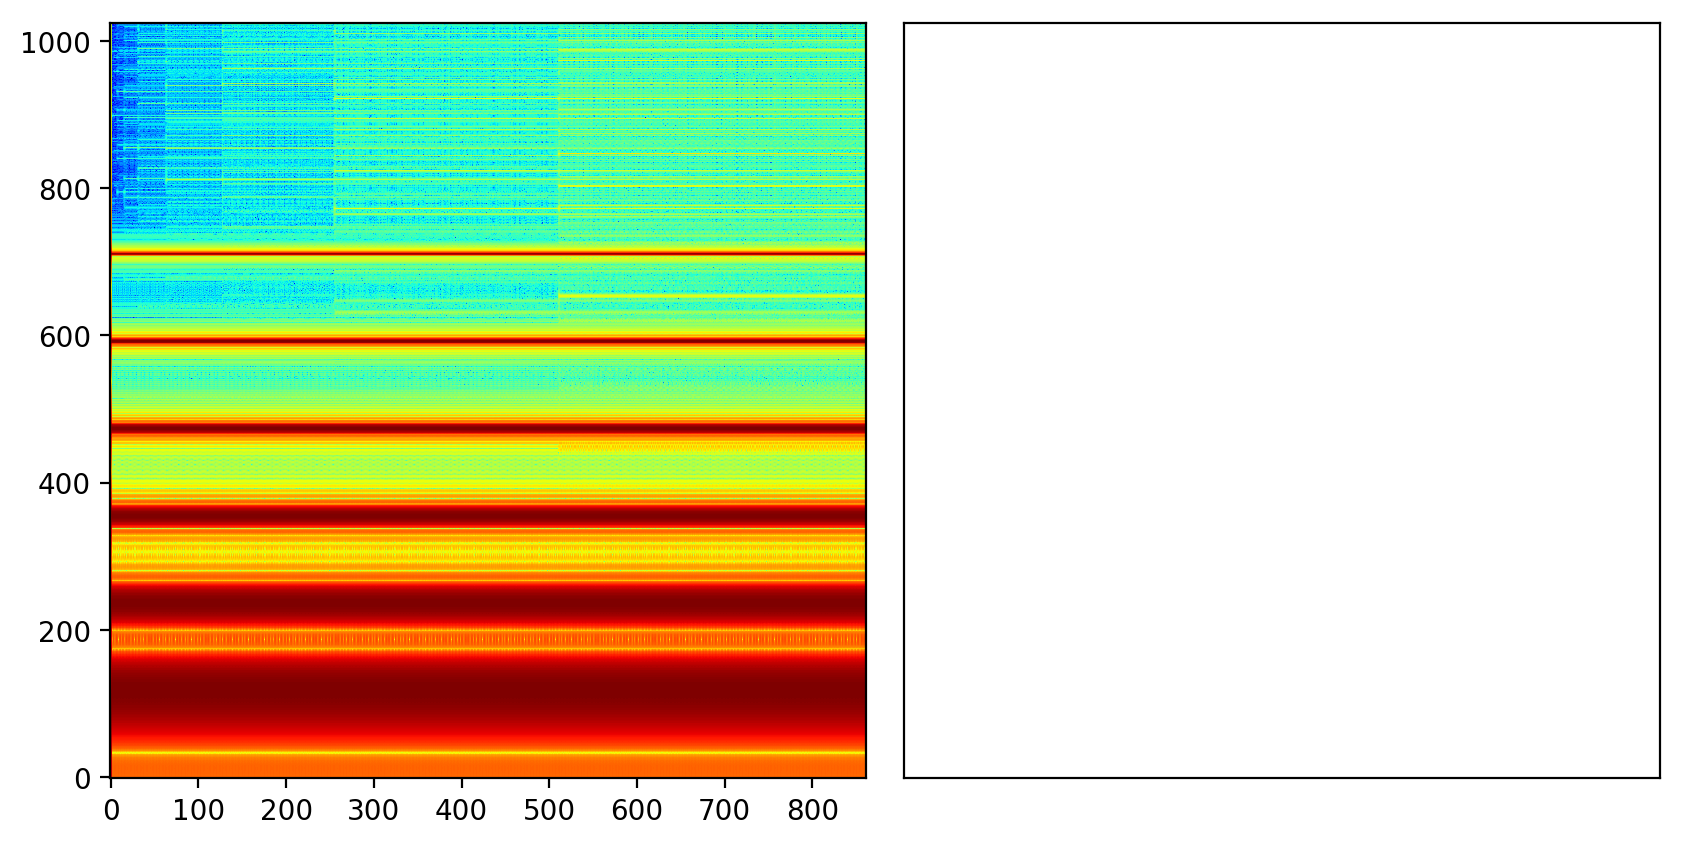

In [14]:
stft_layer = Spectrogram.STFT(freq_scale='log', fmin=fmin, fmax=22050, sr=44100)
stft_log_x = stft_layer(torch.tensor(x[None, None, :]))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,5))
ax[0].imshow(np.log(stft_log_x[0]), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[1].set_xticks([])
# ax[0].title.set_text("nnAudio")
# ax[1].title.set_text("Librosa")
fig.subplots_adjust(wspace = 0.05)

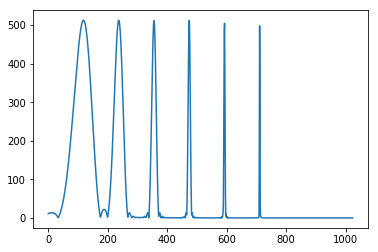

In [15]:
plt.plot(stft_log_x[0][:,40].cpu().numpy())
# plt.plot(output_lib[:,40])

Text(0.5, 1.0, 'Log freq scale STFT')

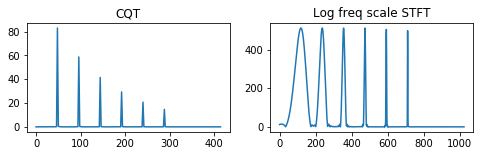

In [17]:
fig, ax = plt.subplots(1,2, figsize=(8,2))
ax[0].plot((cqt_x[0][:,500].cpu().numpy()))
ax[0].set_title('CQT')
ax[1].plot(stft_log_x[0][:,500].cpu().numpy())
ax[1].set_title('Log freq scale STFT')